<a href="https://colab.research.google.com/github/fidhaaysha/Brain-tumor-MRI-Image-classification/blob/main/BRAIN_TUMOR_MRI_IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import drive
import zipfile
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
import shutil
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


In [3]:
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/brain_tumor_dataset'

Mounted at /content/drive


In [4]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
train_path = os.path.join(extract_path, 'Training')
test_path = os.path.join(extract_path, 'Testing')

In [6]:
def count_images_in_folder(path):
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts
train_image_counts = count_images_in_folder(train_path)
test_image_counts = count_images_in_folder(test_path)

print("Training Set Image Counts:")
for class_name, count in train_image_counts.items():
    print(f"{class_name}: {count} images")

print("\nTesting Set Image Counts:")
for class_name, count in test_image_counts.items():
    print(f"{class_name}: {count} images")


Training Set Image Counts:
pituitary: 1457 images
meningioma: 1339 images
glioma: 1321 images
notumor: 1595 images

Testing Set Image Counts:
pituitary: 300 images
meningioma: 306 images
glioma: 300 images
notumor: 405 images


<ipython-input-7-006c12fcf51e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


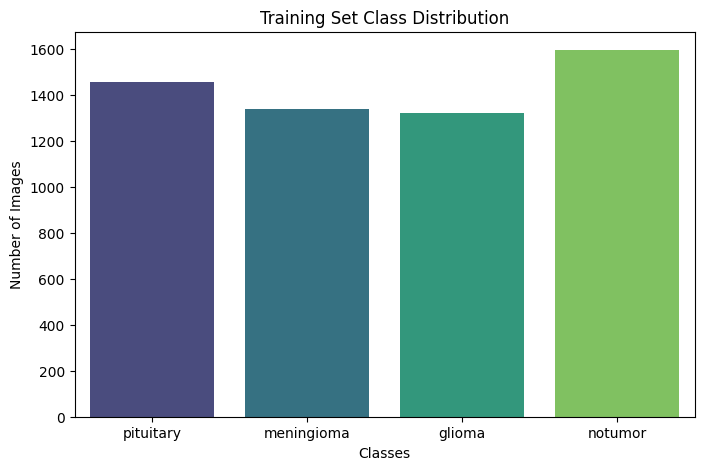

<ipython-input-7-006c12fcf51e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


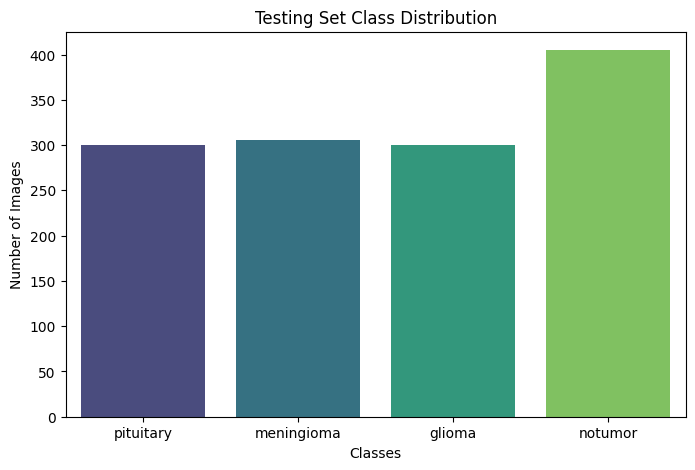

In [7]:
def plot_class_distribution(path, title):
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title(f'{title} Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

# Plot for training and testing subsets
plot_class_distribution(train_path, 'Training Set')
plot_class_distribution(test_path, 'Testing Set')


In [8]:
def create_subset(source_dir, dest_dir, num_samples_per_class):
    os.makedirs(dest_dir, exist_ok=True)
    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        dest_class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        samples = random.sample(os.listdir(source_class_dir), min(num_samples_per_class, len(os.listdir(source_class_dir))))
        for sample in samples:
            shutil.copy(os.path.join(source_class_dir, sample), os.path.join(dest_class_dir, sample))

train_subset_path = '/content/train_subset'
test_subset_path = '/content/test_subset'

create_subset(train_path, train_subset_path, 500)
create_subset(test_path, test_subset_path, 125)

In [9]:
def verify_image_counts(path):
    for class_name in os.listdir(path):
        num_images = len(os.listdir(os.path.join(path, class_name)))
        print(f"{class_name}: {num_images} images")

print("Training Subset Image Counts:")
verify_image_counts(train_subset_path)

print("\nTesting Subset Image Counts:")
verify_image_counts(test_subset_path)


Training Subset Image Counts:
pituitary: 500 images
meningioma: 500 images
glioma: 500 images
notumor: 500 images

Testing Subset Image Counts:
pituitary: 125 images
meningioma: 125 images
glioma: 125 images
notumor: 125 images


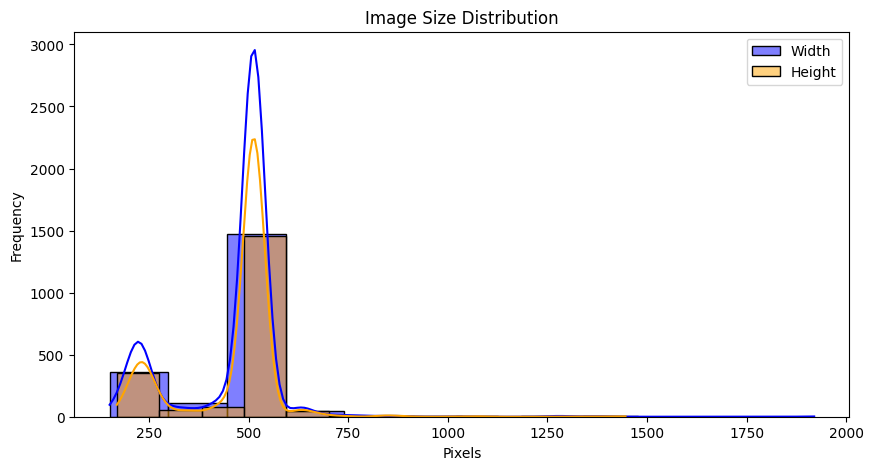

In [10]:
def plot_image_size_distribution(path):
    image_sizes = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(10, 5))
    sns.histplot(widths, kde=True, color='blue', label='Width')
    sns.histplot(heights, kde=True, color='orange', label='Height')
    plt.title('Image Size Distribution')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
plot_image_size_distribution(train_subset_path)

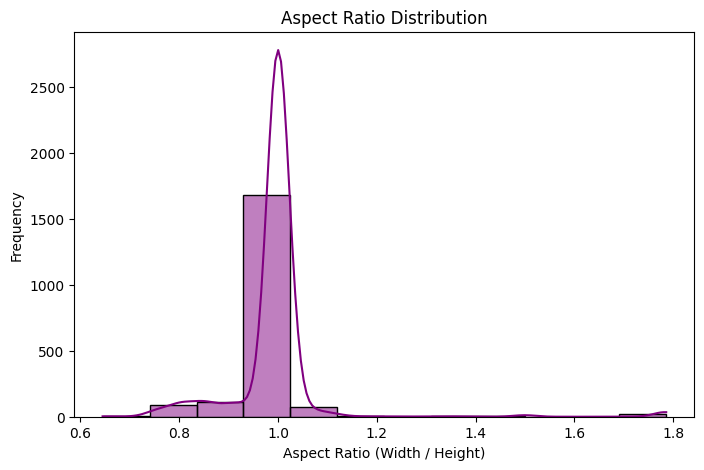

In [11]:
def plot_aspect_ratio_distribution(path):
    aspect_ratios = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    aspect_ratios.append(img.width / img.height)
    plt.figure(figsize=(8, 5))
    sns.histplot(aspect_ratios, kde=True, color='purple')
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width / Height)')
    plt.ylabel('Frequency')
    plt.show()

plot_aspect_ratio_distribution(train_subset_path)

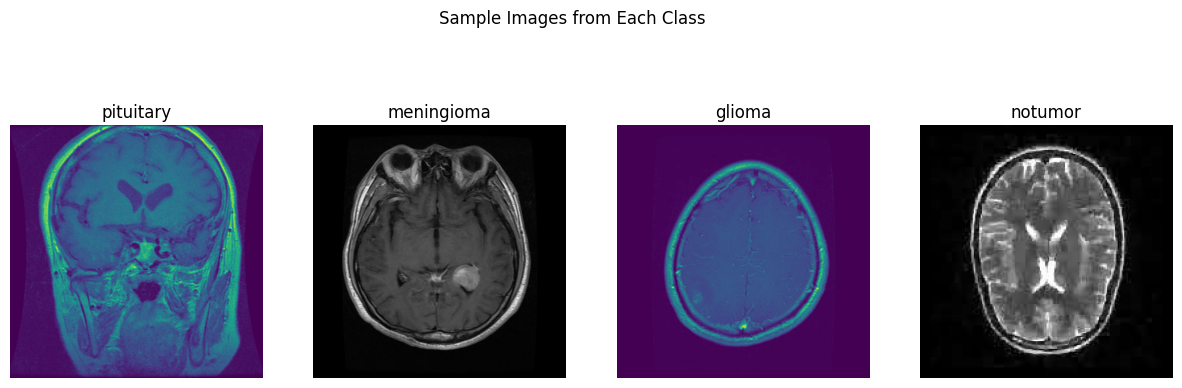

In [12]:
def show_sample_images(path):
    classes = os.listdir(path)
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        sample_image = os.path.join(class_path, os.listdir(class_path)[0])
        img = Image.open(sample_image)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(class_name)
    plt.suptitle("Sample Images from Each Class")
    plt.show()

show_sample_images(train_subset_path)

In [13]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_subset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_subset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2000 images belonging to 4 classes.
Found 500 images belonging to 4 classes.


In [14]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)
]

In [15]:
#model building
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

cnn_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Train CNN Model
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 851ms/step - accuracy: 0.3178 - loss: 1.3935 - val_accuracy: 0.4880 - val_loss: 1.1616 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 836ms/step - accuracy: 0.4657 - loss: 1.1180 - val_accuracy: 0.3400 - val_loss: 1.8286 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 837ms/step - accuracy: 0.5551 - loss: 1.0128 - val_accuracy: 0.4020 - val_loss: 1.4634 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 829ms/step - accuracy: 0.5950 - loss: 0.9645 - val_accuracy: 0.5940 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 834ms/step - accuracy: 0.6297 - loss: 0.8943 - val_accuracy: 0.6700 - val_loss: 0.8180 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 832ms/step - accuracy: 0.6497 - loss: 0.8634 - val_accuracy: 0.5180 - val_loss: 1.2385 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 832ms/step - accuracy: 0.6626 - loss: 0.8047 - val_

In [17]:
#evaluate the model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(validation_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.7984 - loss: 0.5290


In [18]:
#save model
cnn_model.save('/content/cnn_model.keras')

In [19]:
#load model
cnn_model = load_model('/content/cnn_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


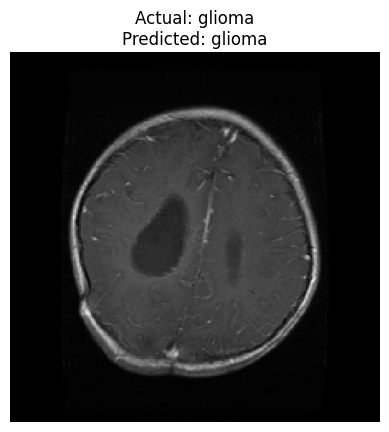

Actual Class: glioma
Predicted Class: glioma


In [24]:
img_path = '/content/test_subset/glioma/Te-gl_0018.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = cnn_model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=-1)

class_labels = ['glioma', 'meningioma', 'nontumor', 'pituitary']
predicted_class_label = class_labels[predicted_class_index[0]]

actual_class_label = img_path.split('/')[-2]

plt.imshow(img)
plt.title(f"Actual: {actual_class_label}\nPredicted: {predicted_class_label}")
plt.axis('off')
plt.show()
print(f"Actual Class: {actual_class_label}")
print(f"Predicted Class: {predicted_class_label}")

In [25]:
y_true = validation_generator.classes
y_pred = cnn_model.predict(validation_generator, batch_size = batch_size)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step


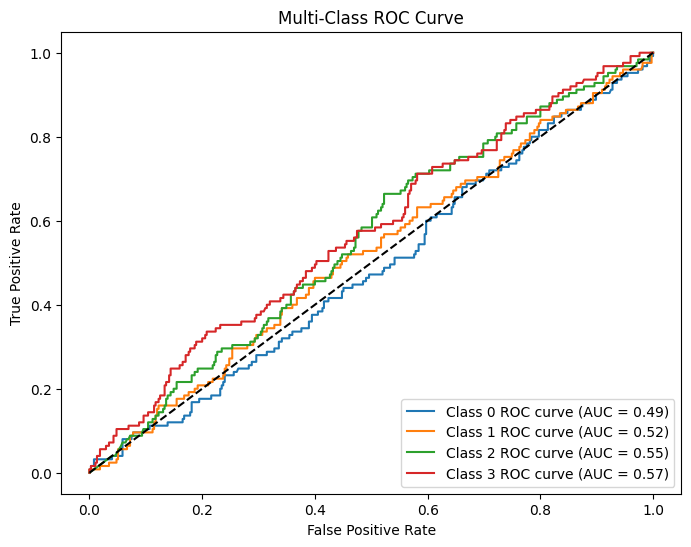

In [26]:
# ROC Curve for Multi-Class
n_classes = validation_generator.num_classes  # Get number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

densenet_model = Model(inputs=base_model_densenet.input, outputs=output)
for layer in base_model_densenet.layers:
    layer.trainable = False

densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history_densenet = densenet_model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8344 - loss: 0.4338 - val_accuracy: 0.8280 - val_loss: 0.4095
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8080 - loss: 0.4616 - val_accuracy: 0.8260 - val_loss: 0.4302
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8055 - loss: 0.4675 - val_accuracy: 0.8420 - val_loss: 0.4153
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8094 - loss: 0.4916 - val_accuracy: 0.8180 - val_loss: 0.4064
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8136 - loss: 0.4469 - val_accuracy: 0.7700 - val_loss: 0.4880
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8045 - loss: 0.4775 - val_accuracy: 0.7960 - val_loss: 0.4561
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8226 - loss: 0.4710 - val_accuracy: 0.8220 - val_loss: 0.4048
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8130 - loss: 0.4843 - val_accuracy: 0.8220 - val_loss:

In [ ]:
densenet_model.save('/content/densenet_model.keras')

In [ ]:
densenet_test_loss, densenet_test_acc = densenet_model.evaluate(validation_generator)
print(f"DenseNet Accuracy: {densenet_test_acc}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2750 - loss: 1.9842
DenseNet Accuracy: 0.2800000011920929


In [ ]:
y_pred = densenet_model.predict(validation_generator, verbose=1)
y_true = validation_generator.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


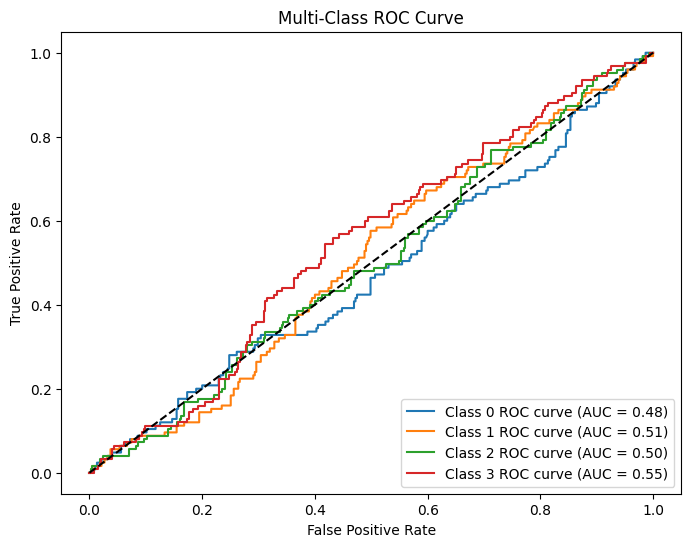

In [ ]:
n_classes = validation_generator.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

efficientnet_model = Model(inputs=base_model_efficientnet.input, outputs=output)
for layer in base_model_efficientnet.layers:
    layer.trainable = False

efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history_efficientnet = efficientnet_model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 715ms/step - accuracy: 0.2304 - loss: 1.3991 - val_accuracy: 0.2500 - val_loss: 1.3877
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 662ms/step - accuracy: 0.2376 - loss: 1.3949 - val_accuracy: 0.2500 - val_loss: 1.3872
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 664ms/step - accuracy: 0.2440 - loss: 1.3941 - val_accuracy: 0.2500 - val_loss: 1.3875
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 650ms/step - accuracy: 0.2244 - loss: 1.3974 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 665ms/step - accuracy: 0.2653 - loss: 1.3895 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 665ms/step - accuracy: 0.2467 - loss: 1.3857 - val_accuracy: 0.2500 - val_loss: 1.3876
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 663ms/step - accuracy: 0.2503 - loss: 1.3911 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 662ms/step - accuracy: 0.2559 - loss: 1.3855 - val_accuracy: 0.250

In [ ]:
efficientnet_loss, efficientnet_acc = efficientnet_model.evaluate(validation_generator)
print(f"Loaded EfficientNet Model Accuracy: {efficientnet_acc}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.2642 - loss: 1.3863
Loaded EfficientNet Model Accuracy: 0.25


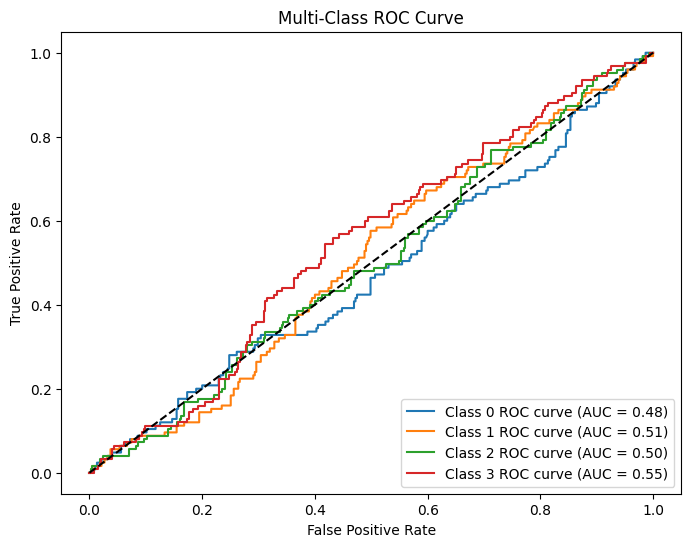

In [ ]:
n_classes = validation_generator.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()
